In [1]:
!pip install albumentations

In [2]:
# Import necessary libraries
import os
import numpy as np  
import pandas as pd  
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from albumentations import Compose, BboxParams, Resize, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ColorJitter
from albumentations.pytorch import ToTensorV2
import cv2
import random
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torch import nn, optim
from torch.nn import functional as F
import copy
import math
from PIL import Image
import albumentations as A  
import warnings
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm  # progress bar

%matplotlib inline  
warnings.filterwarnings("ignore")

In [3]:
# Dictionary to map class IDs to class names
class_names_dict = {
    0: 'pedestrian',
    1: 'people',
    2: 'bicycle',
    3: 'car',
    4: 'van',
    5: 'truck',
    6: 'tricycle',
    7: 'awning-tricycle',
    8: 'bus',
    9: 'motor'
}

In [4]:
n_classes = len(class_names_dict)
print(n_classes)

10


In [5]:
# Define the transformation function
def get_transforms(train=False):
    if train:
        return Compose([
            Resize(600, 600),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))
    else:
        return Compose([
            Resize(600, 600),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))

In [6]:
# Define the transformation function
def get_transforms_augment(train=False):
    if train:
        return Compose([
            Resize(600, 600),
            HorizontalFlip(p=0.3),
            VerticalFlip(p=0.3),
            RandomBrightnessContrast(p=0.1),
            ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))
    else:
        return Compose([
            Resize(600, 600),
            ToTensorV2()
        ], bbox_params=BboxParams(format='coco', label_fields=['category_ids']))

In [7]:
# Define the preprocessing function for dark images
def preprocess_image(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return img_output

In [8]:
# Define the annotation filtering function
def filter_annotations(annotations, min_bbox_area=100):
    filtered_annotations = []
    for annotation in annotations:
        # Filter out annotations with small or unclear bounding boxes
        bbox = annotation['bbox']
        bbox_area = bbox[2] * bbox[3]
        if bbox_area >= min_bbox_area:
            filtered_annotations.append(annotation)
    return filtered_annotations

In [9]:
# Define the dataset class
class VisDroneDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        if split == 'test-dev':
            self.images_dir = os.path.join(root, f'VisDrone2019-DET-{split}', 'images')
            self.annotations_dir = os.path.join(root, f'VisDrone2019-DET-{split}', 'annotations')
        else:
            self.images_dir = os.path.join(root, f'VisDrone2019-DET-{split}', f'VisDrone2019-DET-{split}', 'images')
            self.annotations_dir = os.path.join(root, f'VisDrone2019-DET-{split}', f'VisDrone2019-DET-{split}', 'annotations')
        self.image_ids = sorted([filename.split('.')[0] for filename in os.listdir(self.images_dir)])
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        annotation_path = os.path.join(self.annotations_dir, f'{image_id}.txt')
        
        # Load image
        image = cv2.imread(image_path)
#         image = preprocess_image(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load annotations
        annotations = []
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                elements = line.strip().split(',')
                x_min, y_min, width, height, class_label = int(elements[0]), int(elements[1]), int(elements[2]), int(elements[3]), int(elements[5]) - 1
                if (0 <= class_label <= 9 and width  > 0 and height > 0):
                    annotations.append({
                        'bbox': [x_min, y_min, width, height],  # Albumentations expects [x_min, y_min, width, height]
                        'category_id': class_label
                    })
#         annotations = filter_annotations(annotations)
        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(
                image=image, 
                bboxes=[anno['bbox'] for anno in annotations], 
                category_ids=[anno['category_id'] for anno in annotations]
            )
            image = transformed['image']
            annotations = [{'bbox': box, 'category_id': cat_id} for box, cat_id in zip(transformed['bboxes'], transformed['category_ids'])]
        
        # Prepare target dictionary
        target = {}
        boxes = torch.tensor([anno['bbox'] for anno in annotations], dtype=torch.float32)
        target['boxes'] = torch.stack([torch.tensor([x_min, y_min, x_min + width, y_min + height]) for x_min, y_min, width, height in boxes], dim=0)
        target['labels'] = torch.tensor([anno['category_id'] for anno in annotations], dtype=torch.int64)
        
        return image.div(255), target
    
    def __len__(self):
        return len(self.image_ids)

In [10]:
# Instantiate the dataset
root = "/kaggle/input/visdrone2019"  
visdrone_train_dataset = VisDroneDetection(root, split='train', transforms=get_transforms(train=True))

In [11]:
train_dataset = VisDroneDetection(root, split="train", transforms=get_transforms_augment(train=True))
test_dataset = VisDroneDetection(root, split="test-dev", transforms=get_transforms_augment(train=False))
valid_dataset = VisDroneDetection(root, split="val", transforms=get_transforms_augment(train=False))

In [12]:
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

6471
1610
548


In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [14]:
# Fallback for any labels outside the known range
def get_label_name(label, class_names):
    return class_names.get(label, 'unknown')

In [15]:
def plot_random_image(dataset, class_names):
    # Get a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and target at the random index
    image, target = dataset[idx]

    # Check if the image is already a tensor
    if not isinstance(image, torch.Tensor):
        # Convert image to tensor for drawing bounding boxes
        image = transforms.ToTensor()(image)

    # Prepare boxes and labels for plotting
    boxes = target['boxes']
    labels = target['labels']
    labels_text = [get_label_name(label.item(), class_names) for label in labels]

    # Draw bounding boxes and labels on the image
    drawn_image_tensor = draw_bounding_boxes(image, boxes, labels=labels_text, width=2, colors="red")

    # Convert drawn image tensor back to PIL Image for displaying
    drawn_image_pil = transforms.ToPILImage()(drawn_image_tensor)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(drawn_image_pil)
    plt.axis('off')
    plt.show()


In [16]:
from torchvision.transforms import ToPILImage

In [17]:
def plot_random_image(dataset, class_names):
    import random
    import torchvision.transforms.functional as F

    # Select a random image from the dataset
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    # Convert image tensor to uint8
    image = (image * 255).to(torch.uint8)

    # Extract bounding boxes and labels
    boxes = target['boxes']
    labels = target['labels']
    labels_text = [class_names[label.item()] for label in labels]

    # Draw bounding boxes on the image
    drawn_image_tensor = draw_bounding_boxes(image, boxes, labels=labels_text, width=2, colors="red")
    drawn_image_pil = ToPILImage()(drawn_image_tensor)

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(drawn_image_pil)
    plt.axis('off')
    plt.show()


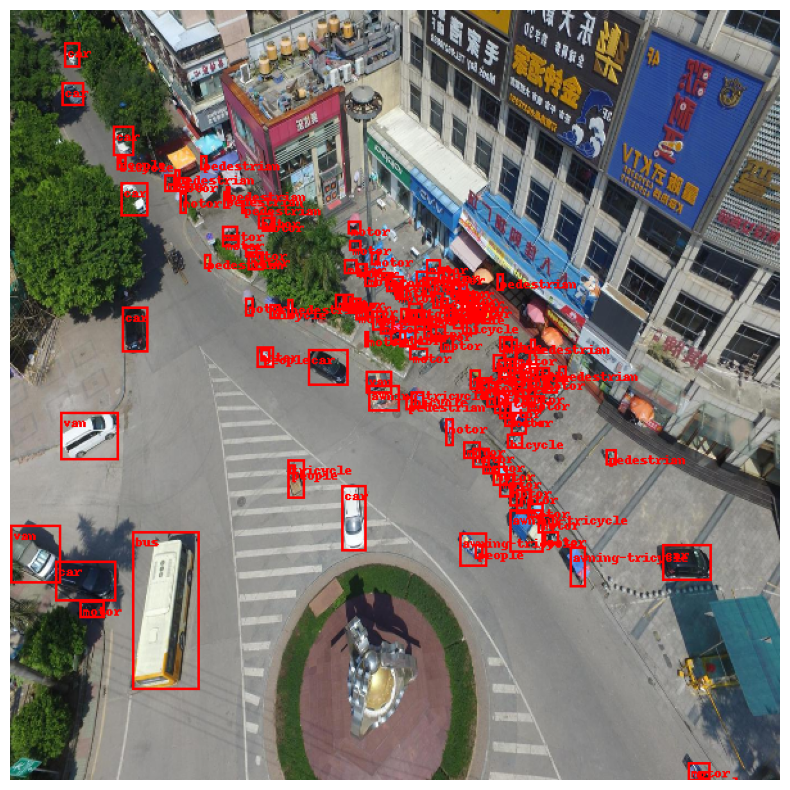

In [18]:
plot_random_image(train_dataset, class_names_dict)

In [19]:
# Load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 168MB/s]


In [20]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [21]:
device = torch.device("cuda") # use GPU to train

In [22]:
model = model.to(device)

In [23]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [24]:
import sys

In [25]:
lst_loss = []

In [26]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    lst_loss.append(np.mean(all_losses))
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [27]:
num_epochs = 40

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 1618/1618 [03:53<00:00,  6.94it/s]


Epoch 0, lr: 0.010000, loss: 1.094018, loss_classifier: 0.413032, loss_box: 0.354583, loss_rpn_box: 0.206630, loss_object: 0.119774


100%|██████████| 1618/1618 [03:45<00:00,  7.17it/s]


Epoch 1, lr: 0.010000, loss: 0.998255, loss_classifier: 0.367701, loss_box: 0.347174, loss_rpn_box: 0.183430, loss_object: 0.099950


100%|██████████| 1618/1618 [03:44<00:00,  7.20it/s]


Epoch 2, lr: 0.010000, loss: 0.961107, loss_classifier: 0.350870, loss_box: 0.342756, loss_rpn_box: 0.174207, loss_object: 0.093273


100%|██████████| 1618/1618 [03:44<00:00,  7.21it/s]


Epoch 3, lr: 0.010000, loss: 0.937708, loss_classifier: 0.340511, loss_box: 0.340880, loss_rpn_box: 0.167917, loss_object: 0.088400


100%|██████████| 1618/1618 [03:45<00:00,  7.17it/s]


Epoch 4, lr: 0.010000, loss: 0.920109, loss_classifier: 0.331715, loss_box: 0.338929, loss_rpn_box: 0.163853, loss_object: 0.085612


100%|██████████| 1618/1618 [03:44<00:00,  7.20it/s]


Epoch 5, lr: 0.010000, loss: 0.903385, loss_classifier: 0.324851, loss_box: 0.335480, loss_rpn_box: 0.160162, loss_object: 0.082893


100%|██████████| 1618/1618 [03:42<00:00,  7.28it/s]


Epoch 6, lr: 0.010000, loss: 0.892888, loss_classifier: 0.320446, loss_box: 0.333622, loss_rpn_box: 0.157765, loss_object: 0.081055


100%|██████████| 1618/1618 [03:43<00:00,  7.23it/s]


Epoch 7, lr: 0.010000, loss: 0.881903, loss_classifier: 0.315025, loss_box: 0.332397, loss_rpn_box: 0.155071, loss_object: 0.079410


100%|██████████| 1618/1618 [03:41<00:00,  7.29it/s]


Epoch 8, lr: 0.010000, loss: 0.874529, loss_classifier: 0.311427, loss_box: 0.331897, loss_rpn_box: 0.153570, loss_object: 0.077635


100%|██████████| 1618/1618 [03:40<00:00,  7.32it/s]


Epoch 9, lr: 0.010000, loss: 0.865501, loss_classifier: 0.307899, loss_box: 0.329740, loss_rpn_box: 0.151269, loss_object: 0.076593


100%|██████████| 1618/1618 [03:40<00:00,  7.34it/s]


Epoch 10, lr: 0.010000, loss: 0.857031, loss_classifier: 0.304000, loss_box: 0.328886, loss_rpn_box: 0.149569, loss_object: 0.074577


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 11, lr: 0.010000, loss: 0.851339, loss_classifier: 0.301399, loss_box: 0.327980, loss_rpn_box: 0.148061, loss_object: 0.073899


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 12, lr: 0.010000, loss: 0.846384, loss_classifier: 0.299003, loss_box: 0.327742, loss_rpn_box: 0.146684, loss_object: 0.072955


100%|██████████| 1618/1618 [03:39<00:00,  7.36it/s]


Epoch 13, lr: 0.010000, loss: 0.838367, loss_classifier: 0.295738, loss_box: 0.324862, loss_rpn_box: 0.145345, loss_object: 0.072422


100%|██████████| 1618/1618 [03:39<00:00,  7.36it/s]


Epoch 14, lr: 0.010000, loss: 0.835948, loss_classifier: 0.294716, loss_box: 0.325928, loss_rpn_box: 0.144026, loss_object: 0.071278


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 15, lr: 0.010000, loss: 0.831519, loss_classifier: 0.292465, loss_box: 0.325302, loss_rpn_box: 0.143247, loss_object: 0.070505


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 16, lr: 0.010000, loss: 0.827797, loss_classifier: 0.291635, loss_box: 0.325330, loss_rpn_box: 0.141863, loss_object: 0.068969


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 17, lr: 0.010000, loss: 0.822753, loss_classifier: 0.289125, loss_box: 0.323911, loss_rpn_box: 0.141040, loss_object: 0.068677


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 18, lr: 0.010000, loss: 0.820272, loss_classifier: 0.287768, loss_box: 0.324234, loss_rpn_box: 0.140258, loss_object: 0.068012


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 19, lr: 0.010000, loss: 0.813529, loss_classifier: 0.284696, loss_box: 0.322298, loss_rpn_box: 0.139242, loss_object: 0.067293


100%|██████████| 1618/1618 [03:39<00:00,  7.38it/s]


Epoch 20, lr: 0.010000, loss: 0.810817, loss_classifier: 0.283924, loss_box: 0.322286, loss_rpn_box: 0.138397, loss_object: 0.066210


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 21, lr: 0.010000, loss: 0.806380, loss_classifier: 0.282182, loss_box: 0.320350, loss_rpn_box: 0.137426, loss_object: 0.066423


100%|██████████| 1618/1618 [03:39<00:00,  7.36it/s]


Epoch 22, lr: 0.010000, loss: 0.803882, loss_classifier: 0.281317, loss_box: 0.320382, loss_rpn_box: 0.136863, loss_object: 0.065320


100%|██████████| 1618/1618 [03:40<00:00,  7.34it/s]


Epoch 23, lr: 0.010000, loss: 0.799829, loss_classifier: 0.278346, loss_box: 0.320389, loss_rpn_box: 0.136109, loss_object: 0.064985


100%|██████████| 1618/1618 [03:39<00:00,  7.36it/s]


Epoch 24, lr: 0.010000, loss: 0.799095, loss_classifier: 0.278435, loss_box: 0.319978, loss_rpn_box: 0.135870, loss_object: 0.064812


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 25, lr: 0.010000, loss: 0.796004, loss_classifier: 0.276821, loss_box: 0.319890, loss_rpn_box: 0.134964, loss_object: 0.064329


100%|██████████| 1618/1618 [03:39<00:00,  7.36it/s]


Epoch 26, lr: 0.010000, loss: 0.792543, loss_classifier: 0.275870, loss_box: 0.319288, loss_rpn_box: 0.134318, loss_object: 0.063067


100%|██████████| 1618/1618 [03:40<00:00,  7.35it/s]


Epoch 27, lr: 0.010000, loss: 0.788403, loss_classifier: 0.273762, loss_box: 0.317380, loss_rpn_box: 0.134042, loss_object: 0.063219


100%|██████████| 1618/1618 [03:40<00:00,  7.34it/s]


Epoch 28, lr: 0.010000, loss: 0.788297, loss_classifier: 0.273527, loss_box: 0.318127, loss_rpn_box: 0.133662, loss_object: 0.062980


100%|██████████| 1618/1618 [03:41<00:00,  7.30it/s]


Epoch 29, lr: 0.010000, loss: 0.786375, loss_classifier: 0.272898, loss_box: 0.318791, loss_rpn_box: 0.132485, loss_object: 0.062202


100%|██████████| 1618/1618 [03:41<00:00,  7.29it/s]


Epoch 30, lr: 0.010000, loss: 0.784271, loss_classifier: 0.272239, loss_box: 0.317775, loss_rpn_box: 0.132562, loss_object: 0.061695


100%|██████████| 1618/1618 [03:42<00:00,  7.28it/s]


Epoch 31, lr: 0.010000, loss: 0.779778, loss_classifier: 0.270196, loss_box: 0.316678, loss_rpn_box: 0.131444, loss_object: 0.061460


100%|██████████| 1618/1618 [03:42<00:00,  7.28it/s]


Epoch 32, lr: 0.010000, loss: 0.775984, loss_classifier: 0.268454, loss_box: 0.315302, loss_rpn_box: 0.131168, loss_object: 0.061059


100%|██████████| 1618/1618 [03:40<00:00,  7.32it/s]


Epoch 33, lr: 0.010000, loss: 0.778151, loss_classifier: 0.269092, loss_box: 0.318077, loss_rpn_box: 0.130822, loss_object: 0.060160


100%|██████████| 1618/1618 [03:41<00:00,  7.32it/s]


Epoch 34, lr: 0.010000, loss: 0.776502, loss_classifier: 0.268452, loss_box: 0.317375, loss_rpn_box: 0.130546, loss_object: 0.060128


100%|██████████| 1618/1618 [03:41<00:00,  7.31it/s]


Epoch 35, lr: 0.010000, loss: 0.774678, loss_classifier: 0.267122, loss_box: 0.318078, loss_rpn_box: 0.129774, loss_object: 0.059704


100%|██████████| 1618/1618 [03:41<00:00,  7.31it/s]


Epoch 36, lr: 0.010000, loss: 0.771321, loss_classifier: 0.265134, loss_box: 0.316703, loss_rpn_box: 0.130004, loss_object: 0.059480


100%|██████████| 1618/1618 [03:39<00:00,  7.38it/s]


Epoch 37, lr: 0.010000, loss: 0.768759, loss_classifier: 0.265343, loss_box: 0.316197, loss_rpn_box: 0.128646, loss_object: 0.058573


100%|██████████| 1618/1618 [03:39<00:00,  7.37it/s]


Epoch 38, lr: 0.010000, loss: 0.767790, loss_classifier: 0.263067, loss_box: 0.315701, loss_rpn_box: 0.129401, loss_object: 0.059621


100%|██████████| 1618/1618 [03:39<00:00,  7.38it/s]

Epoch 39, lr: 0.010000, loss: 0.767437, loss_classifier: 0.264317, loss_box: 0.315712, loss_rpn_box: 0.128553, loss_object: 0.058855


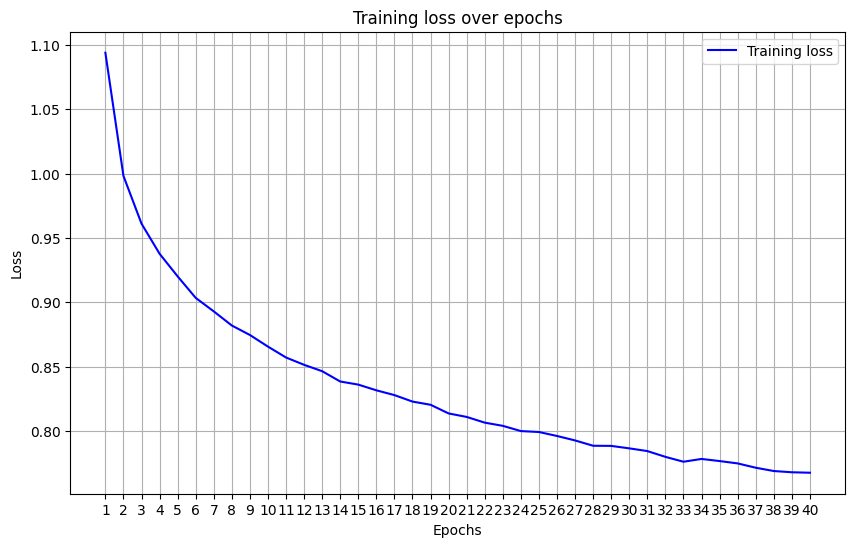

In [28]:
epochs = range(1, len(lst_loss) + 1)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(epochs, lst_loss, 'b', label='Training loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(lst_loss) + 1, 1))  # Customize the x-axis ticks
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Save the trained model
torch.save(model.state_dict(), 'visdrone2019_faster_rcnn_2.pth')

In [30]:
model.eval()
torch.cuda.empty_cache()

In [31]:
classes = ['pedestrian', 'people', 'bicycle', 'car', 'van','truck', 'tricycle', 'awning-tricycle',
           'bus','motor']

In [32]:
# Load the saved state dictionary into the model
model.load_state_dict(torch.load('visdrone2019_faster_rcnn_2.pth'))

# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## Predict a random image

In [33]:
idx = random.randint(0, len(test_dataset) - 1)
img, gt = test_dataset[idx]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

**Prediction**

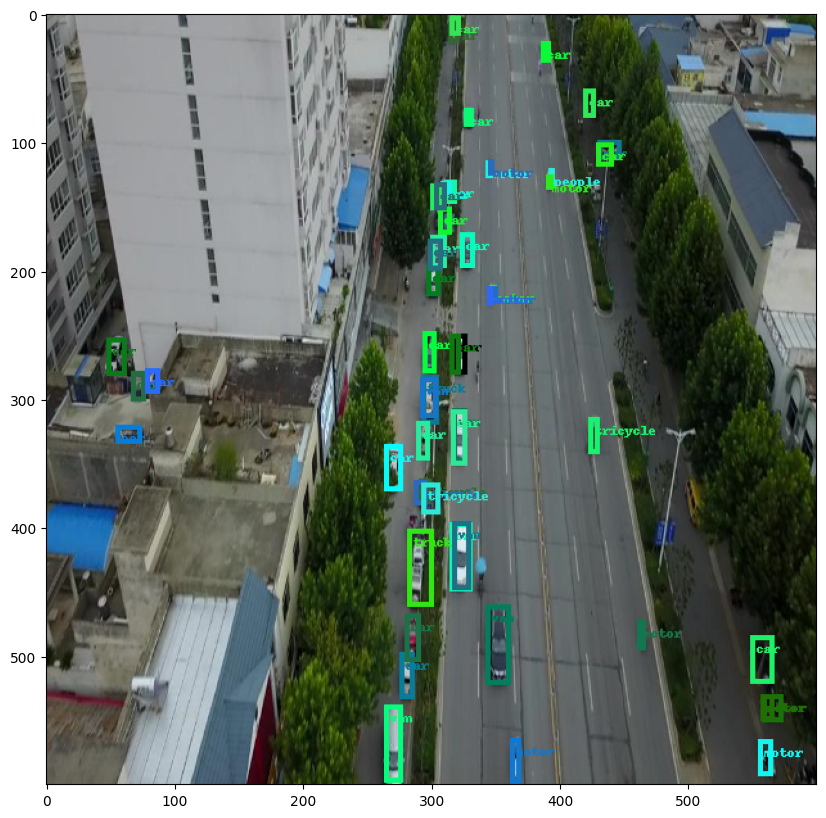

In [34]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.25],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.25].tolist()], width=4
).permute(1, 2, 0))

**Ground truth**

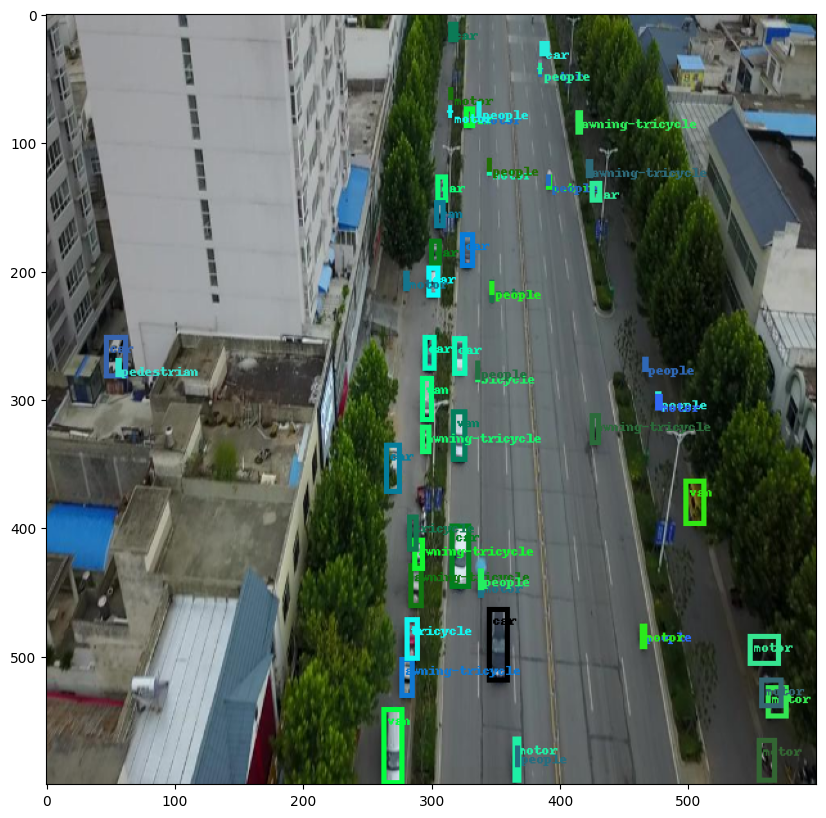

In [35]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    gt['boxes'], [classes[i] for i in gt['labels'].tolist()], width=4
).permute(1, 2, 0))

In [36]:
def create_df_mAP(test_dataset, model, class_names_dict):
    boxes_gt = []
    class_gt = []
    img_id_gt = []

    boxes_pred = []
    class_pred = []
    img_id_pred = []
    scores_pred = []
    for i in range(len(test_dataset)): # loop over each image in test set
        img_id = 'img_' + str(i)
        img, gt = test_dataset[i]
        img_int = torch.tensor(img*255, dtype=torch.uint8)
        with torch.no_grad():
            prediction = model([img.to(device)])
            pred = prediction[0]
            
        for class_id, class_name in class_names_dict.items():
            class_name_i = class_name
            predicted_boxes_idx = np.where(np.asarray(pred['labels'].tolist()) == class_id)[0]
            predicted_scores_idx = np.where(np.asarray(pred['scores'].tolist()) >= 0.25)[0]
            common_idx = list(set(predicted_boxes_idx) & set(predicted_scores_idx))
  
            predicted_boxes = np.asarray(pred['boxes'].tolist())[common_idx]
            predicted_labels = np.asarray(pred['labels'].tolist())[common_idx]
            predicted_scores = np.asarray(pred['scores'].tolist())[common_idx]
            
            if(len(predicted_boxes) != 0):
                for k in range(len(predicted_boxes)):
                    boxes_pred.append(np.asarray(predicted_boxes[k],dtype="int")) 
                    class_pred.append(class_names_dict.get(predicted_labels[k]))
                    scores_pred.append(predicted_scores[k])
                    img_id_pred.append(img_id)

            gt_idx = np.where(np.array(gt['labels'].tolist()) == class_id)
            gt_boxes = np.array(gt['boxes'].tolist())[gt_idx]
            gt_labels = np.array(gt['labels'].tolist())[gt_idx]
            
            if(len(gt_boxes) != 0):
                for j in range(len(gt_boxes)):
                    boxes_gt.append(np.asarray(gt_boxes[j],dtype="int")) 
                    class_gt.append(class_names_dict.get(gt_labels[j]))
                    img_id_gt.append(img_id)
    pred_df = pd.DataFrame({'box_pred': boxes_pred, 'confidence': scores_pred, 'class': class_pred, 'img_id': img_id_pred})
    gt_df = pd.DataFrame({'box_gt': boxes_gt, 'class': class_gt, 'img_id': img_id_gt})
    return gt_df,pred_df

In [37]:
gt_df,pred_df = create_df_mAP(test_dataset, model, class_names_dict)

In [38]:
gt_df

,box_gt,class,img_id
0,"[500, 124, 504, 141]",pedestrian,img_0
1,"[467, 108, 474, 123]",pedestrian,img_0
2,"[457, 124, 462, 138]",pedestrian,img_0
3,"[382, 77, 385, 85]",pedestrian,img_0
4,"[302, 363, 350, 414]",car,img_0
...,...,...,...
75097,"[153, 430, 161, 445]",bus,img_1609
75098,"[179, 426, 187, 441]",bus,img_1609
75099,"[196, 426, 204, 439]",bus,img_1609
75100,"[211, 421, 220, 436]",bus,img_1609


In [39]:
def convert_bbox_format(bbox):
    x_min, y_min, x_max, y_max = bbox
    return [(x_min, y_min), (x_max, y_max)]

In [40]:
# Apply the function to the 'box_gt' column
gt_df['box_gt'] = gt_df['box_gt'].apply(convert_bbox_format)

In [41]:
gt_df

,box_gt,class,img_id
0,"[(500, 124), (504, 141)]",pedestrian,img_0
1,"[(467, 108), (474, 123)]",pedestrian,img_0
2,"[(457, 124), (462, 138)]",pedestrian,img_0
3,"[(382, 77), (385, 85)]",pedestrian,img_0
4,"[(302, 363), (350, 414)]",car,img_0
...,...,...,...
75097,"[(153, 430), (161, 445)]",bus,img_1609
75098,"[(179, 426), (187, 441)]",bus,img_1609
75099,"[(196, 426), (204, 439)]",bus,img_1609
75100,"[(211, 421), (220, 436)]",bus,img_1609


In [42]:
pred_df

,box_pred,confidence,class,img_id
0,"[467, 109, 473, 119]",0.339070,people,img_0
1,"[501, 125, 507, 135]",0.334377,people,img_0
2,"[468, 112, 473, 122]",0.304064,people,img_0
3,"[465, 109, 477, 124]",0.284632,people,img_0
4,"[498, 126, 504, 137]",0.352026,people,img_0
...,...,...,...,...
68649,"[178, 427, 190, 438]",0.316984,truck,img_1609
68650,"[176, 425, 194, 444]",0.380045,truck,img_1609
68651,"[127, 426, 157, 446]",0.514618,bus,img_1609
68652,"[68, 446, 91, 462]",0.428178,bus,img_1609


In [43]:
# Apply the function to the 'box_gt' column
pred_df['box_pred'] = pred_df['box_pred'].apply(convert_bbox_format)

In [44]:
pred_df

,box_pred,confidence,class,img_id
0,"[(467, 109), (473, 119)]",0.339070,people,img_0
1,"[(501, 125), (507, 135)]",0.334377,people,img_0
2,"[(468, 112), (473, 122)]",0.304064,people,img_0
3,"[(465, 109), (477, 124)]",0.284632,people,img_0
4,"[(498, 126), (504, 137)]",0.352026,people,img_0
...,...,...,...,...
68649,"[(178, 427), (190, 438)]",0.316984,truck,img_1609
68650,"[(176, 425), (194, 444)]",0.380045,truck,img_1609
68651,"[(127, 426), (157, 446)]",0.514618,bus,img_1609
68652,"[(68, 446), (91, 462)]",0.428178,bus,img_1609


In [45]:
gt_df.to_csv('/kaggle/working/' + 'gt_test_df.csv', index=False)
pred_df.to_csv('/kaggle/working/' + 'pred_test_df.csv', index=False)

In [46]:
from shapely.geometry import Polygon
from shapely.geometry import Polygon, mapping

In [47]:
def calculate_IoU(box_A, box_B):
    top_left_A = box_A[0]
    bottom_right_A = box_A[1]
    top_right_A = (bottom_right_A[0], top_left_A[1])
    bottom_left_A = (top_left_A[0], bottom_right_A[1])
    
    top_left_B = box_B[0]
    bottom_right_B = box_B[1]
    top_right_B = (bottom_right_B[0], top_left_B[1])
    bottom_left_B = (top_left_B[0], bottom_right_B[1])
    
    A = Polygon([top_left_A, top_right_A, bottom_right_A, bottom_left_A]).buffer(0)
    B = Polygon([top_left_B, top_right_B, bottom_right_B, bottom_left_B])
    
    if(A.intersection(B)):
        intersection = A.intersection(B).area
        union = A.union(B).area
        iou = intersection/union
        return iou
    else:
        return 0

In [48]:
def IoU_per_class(sub_gt_df, sub_pred_df_sorted, class_name):
    IoU = []
    for i in range(sub_pred_df_sorted.shape[0]):
        box_pred_i = sub_pred_df_sorted.iloc[i]['box_pred']
        img_id = sub_pred_df_sorted.iloc[i]['img_id']
        
        boxes_gt_i_df = sub_gt_df[sub_gt_df['img_id'] == img_id]
        if(boxes_gt_i_df.shape[0] == 0):
            iou = 0.0
            IoU.append(iou)
        else:
            max_iou = -1
            idx_max = None
            for j in range(boxes_gt_i_df.shape[0]):
                iou = calculate_IoU(box_pred_i, boxes_gt_i_df.iloc[j]['box_gt'])
                if (iou > max_iou):
                    max_iou = iou
                    idx_max = boxes_gt_i_df.iloc[[j]].index.values[0]
            IoU.append(max_iou)
            if(max_iou > 0.0001):
                sub_gt_df.drop(index = [idx_max]) 
    sub_pred_df_sorted['IoU'] = IoU
    return sub_pred_df_sorted

In [49]:
IoU_threshold = 0.5
def check_IoU(df, col_name):
    df['IoU > IoU_threshold'] = df[col_name].apply(lambda x: x >= IoU_threshold)
    return df

In [50]:
def cumulative(df, IoU_bool, Acc_TP, Acc_FP):
    # base
    cum_TP = 0
    cum_FP = 0
    if (df[IoU_bool].iloc[0] == True):
        df.loc[0, Acc_TP] = cum_TP + 1
        cum_TP+=1
    else:
        df.loc[0, Acc_FP] = cum_FP + 1 
        cum_FP+=1
    # loop 
    for i in range(1, df.shape[0]):
        if (df[IoU_bool].iloc[i] == True):
            cum_TP+=1
            df.loc[i, Acc_TP] = cum_TP
            df.loc[i, Acc_FP] = cum_FP
        else:
            cum_FP+=1
            df.loc[i, Acc_TP] = cum_TP
            df.loc[i, Acc_FP] = cum_FP         
    return df

In [51]:
def get_the_rest(sorted_array, value):
    idx = None
    flag = False
    for i in range(len(sorted_array)):
        value_i = sorted_array[i]
        if(value_i >= value):
            idx = i
            flag = True
            break
    return flag, idx

In [52]:
def calculate_AP_n_points(precisions, recalls, step = 0.01):
    recall_interpolations = np.around(np.arange(0, 1+step, step, dtype=float), 2)
    precision_interpolations = []
    for i in range(len(recall_interpolations)):
        value = recall_interpolations[i]
        flag, idx = get_the_rest(recalls, value)

        if(flag):
            precisions_temp = precisions[idx:]
            max_precision = precisions_temp.max()
            precision_interpolations.append(max_precision)
        else:
            precision_interpolations.append(0)
    return precision_interpolations, recall_interpolations    

In [53]:
def riemann_sum(precisions, recalls, type_sum):
    cumulative = 0
    for i in range(len(recalls)-1):
        range_rc = recalls[i+1] - recalls[i]
        if(type_sum == 'right'):
            cumulative+=range_rc*precisions[i+1]
        if(type_sum == 'left'):
            cumulative+=range_rc*precisions[i]
        if(type_sum == 'mid'):
            cumulative+=range_rc*((precisions[i]+precisions[i+1])/2)
    return cumulative   

In [54]:
def calculate_AP_all_points(precisions, recalls):
    recall_interpolations = recalls
    precision_interpolations = []
    for i in range(len(recall_interpolations)):
        value = recall_interpolations[i]
        flag, idx = get_the_rest(recalls, value)
        if(flag):
            precisions_temp = precisions[idx:]
            max_precision = precisions_temp.max()
            precision_interpolations.append(max_precision)
        else:
            precision_interpolations.append(0)
    return precision_interpolations, recall_interpolations    

In [55]:
def AP_per_class(gt_df, pred_df, class_name):
    sub_gt_df = gt_df[gt_df['class'] == class_name].reset_index(drop = True)
    num_of_gt = len(sub_gt_df)
    
    sub_pred_df = pred_df[pred_df['class'] == class_name].reset_index(drop = True)
    if(sub_pred_df.shape[0] != 0):
        sub_pred_df_sorted = sub_pred_df.sort_values(by=['confidence'], ascending=False).reset_index(drop = True)

        sub_pred_df_sorted = IoU_per_class(sub_gt_df, sub_pred_df_sorted, class_name)
        sub_pred_df_sorted = check_IoU(sub_pred_df_sorted, 'IoU')

        sub_pred_df_sorted['Acc_TP'], sub_pred_df_sorted['Acc_FP'] = [0,0]
        sub_pred_df_sorted = cumulative(sub_pred_df_sorted, 'IoU > IoU_threshold', 'Acc_TP', 'Acc_FP')

        sub_pred_df_sorted['Precision'] = sub_pred_df_sorted.apply(lambda x: x['Acc_TP']/(x['Acc_TP'] + x['Acc_FP']), axis=1)
        sub_pred_df_sorted['Recall'] = sub_pred_df_sorted['Acc_TP'].apply(lambda x: x/num_of_gt)
        
        precisions = sub_pred_df_sorted['Precision'].values
        recalls = sub_pred_df_sorted['Recall'].values
        precision_interpolations, recall_interpolations = calculate_AP_n_points(precisions, recalls, step = 0.01)
        cum_sum = riemann_sum(precision_interpolations, recall_interpolations, type_sum = 'mid')
        return cum_sum
    else:
        return 0

In [56]:
gt_df[gt_df['img_id'] == 'img_0']['class'].unique()

array(['pedestrian', 'car', 'van', 'truck', 'motor'], dtype=object)

In [57]:
pred_df[pred_df['img_id'] == 'img_0']['class'].unique()

array(['people', 'car', 'van', 'truck', 'motor'], dtype=object)

In [58]:
classes

['pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor']

In [59]:
AP_lst = []
for x in classes:
    AP_x = AP_per_class(gt_df, pred_df, x)
    AP_lst.append(AP_x)

In [60]:
AP_lst

[0,
 0.031632880113514374,
 0.01769205898409901,
 0.5199845905731297,
 0.1768288540224745,
 0.20497004579077194,
 0.08214552550268733,
 0.04097219993734208,
 0.34639499520300154,
 0.08667139514855257]

In [61]:
for i in range(len(classes)):
    print('Class: {} with AP = {}'.format(classes[i], AP_lst[i]))

Class: pedestrian with AP = 0
Class: people with AP = 0.031632880113514374
Class: bicycle with AP = 0.01769205898409901
Class: car with AP = 0.5199845905731297
Class: van with AP = 0.1768288540224745
Class: truck with AP = 0.20497004579077194
Class: tricycle with AP = 0.08214552550268733
Class: awning-tricycle with AP = 0.04097219993734208
Class: bus with AP = 0.34639499520300154
Class: motor with AP = 0.08667139514855257


In [62]:
mAP = np.mean(AP_lst)
mAP

0.15072925452755728